In [24]:

import multiprocessing
import os
import re
import signal
from math import ceil
from os.path import join

import numpy as np
import torch
from numpy.random import choice
from torchtext.data import Field, TabularDataset

# from paragraphvec.utils import DATA_DIR

%matplotlib inline

## Data

In [8]:

def load_dataset(file_name):
    """Loads contents from a file in the *data* directory into a
    torchtext.data.TabularDataset instance.
    """
    file_path = join(DATA_DIR, file_name)
    text_field = Field(pad_token=None, tokenize=_tokenize_str)

    dataset = TabularDataset(
        path=file_path,
        format='csv',
        fields=[('text', text_field)],
        skip_header=True)

    text_field.build_vocab(dataset)
    return dataset


def _tokenize_str(str_):
    # keep only alphanumeric and punctations
    str_ = re.sub(r'[^A-Za-z0-9(),.!?\'`]', ' ', str_)
    # remove multiple whitespace characters
    str_ = re.sub(r'\s{2,}', ' ', str_)
    # punctations to tokens
    str_ = re.sub(r'\(', ' ( ', str_)
    str_ = re.sub(r'\)', ' ) ', str_)
    str_ = re.sub(r',', ' , ', str_)
    str_ = re.sub(r'\.', ' . ', str_)
    str_ = re.sub(r'!', ' ! ', str_)
    str_ = re.sub(r'\?', ' ? ', str_)
    # split contractions into multiple tokens
    str_ = re.sub(r'\'s', ' \'s', str_)
    str_ = re.sub(r'\'ve', ' \'ve', str_)
    str_ = re.sub(r'n\'t', ' n\'t', str_)
    str_ = re.sub(r'\'re', ' \'re', str_)
    str_ = re.sub(r'\'d', ' \'d', str_)
    str_ = re.sub(r'\'ll', ' \'ll', str_)
    # lower case
    return str_.strip().lower().split()


class NCEData(object):
    """An infinite, parallel (multiprocess) batch generator for
    noise-contrastive estimation of word vector models.

    Parameters
    ----------
    dataset: torchtext.data.TabularDataset
        Dataset from which examples are generated. A column labeled *text*
        is expected and should be comprised of a list of tokens. Each row
        should represent a single document.

    batch_size: int
        Number of examples per single gradient update.

    context_size: int
        Half the size of a neighbourhood of target words (i.e. how many
        words left and right are regarded as context).

    num_noise_words: int
        Number of noise words to sample from the noise distribution.

    max_size: int
        Maximum number of pre-generated batches.

    num_workers: int
        Number of jobs to run in parallel. If value is set to -1, total number
        of machine CPUs is used.
    """
    # code inspired by parallel generators in https://github.com/fchollet/keras
    def __init__(self, dataset, batch_size, context_size,
                 num_noise_words, max_size, num_workers):
        self.max_size = max_size

        self.num_workers = num_workers if num_workers != -1 else os.cpu_count()
        if self.num_workers is None:
            self.num_workers = 1

        self._generator = _NCEGenerator(
            dataset,
            batch_size,
            context_size,
            num_noise_words,
            _NCEGeneratorState(context_size))

        self._queue = []
        self._stop_event = None
        self._processes = []

    def __len__(self):
        return len(self._generator)

    def vocabulary_size(self):
        return self._generator.vocabulary_size()



class _NCEGenerator(object):
    """An infinite, process-safe batch generator for noise-contrastive
    estimation of word vector models.

    Parameters
    ----------
    state: paragraphvec.data._NCEGeneratorState
        Initial (indexing) state of the generator.

    For other parameters see the NCEData class.
    """
    def __init__(self, dataset, batch_size, context_size,
                 num_noise_words, state):
        self.dataset = dataset
        self.batch_size = batch_size
        self.context_size = context_size
        self.num_noise_words = num_noise_words

        self._vocabulary = self.dataset.fields['text'].vocab
        self._sample_noise = None
        self._init_noise_distribution()
        self._state = state

    def _init_noise_distribution(self):
        # we use a unigram distribution raised to the 3/4rd power,
        # as proposed by T. Mikolov et al. in Distributed Representations
        # of Words and Phrases and their Compositionality
        probs = np.zeros(len(self._vocabulary) - 1)

        for word, freq in self._vocabulary.freqs.items():
            probs[self._word_to_index(word)] = freq

        probs = np.power(probs, 0.75)
        probs /= np.sum(probs)

        self._sample_noise = lambda: choice(
            probs.shape[0], self.num_noise_words, p=probs).tolist()

    def __len__(self):
        num_examples = sum(self._num_examples_in_doc(d) for d in self.dataset)
        return ceil(num_examples / self.batch_size)

    def vocabulary_size(self):
        return len(self._vocabulary) - 1

    def next(self):
        """Updates state for the next process in a process-safe manner
        and generates the current batch."""
        prev_doc_id, prev_in_doc_pos = self._state.update_state(
            self.dataset,
            self.batch_size,
            self.context_size,
            self._num_examples_in_doc)

        # generate the actual batch
        batch = _NCEBatch(self.context_size)

        while len(batch) < self.batch_size:
            if prev_doc_id == len(self.dataset):
                # last document exhausted
                batch.torch_()
                return batch
            if prev_in_doc_pos <= (len(self.dataset[prev_doc_id].text) - 1
                                   - self.context_size):
                # more examples in the current document
                self._add_example_to_batch(prev_doc_id, prev_in_doc_pos, batch)
                prev_in_doc_pos += 1
            else:
                # go to the next document
                prev_doc_id += 1
                prev_in_doc_pos = self.context_size

        batch.torch_()
        return batch

    def _num_examples_in_doc(self, doc, in_doc_pos=None):
        if in_doc_pos is not None:
            # number of remaining
            if len(doc.text) - in_doc_pos >= self.context_size + 1:
                return len(doc.text) - in_doc_pos - self.context_size
            return 0

        if len(doc.text) >= 2 * self.context_size + 1:
            # total number
            return len(doc.text) - 2 * self.context_size
        return 0

    def _add_example_to_batch(self, doc_id, in_doc_pos, batch):
        doc = self.dataset[doc_id].text
        batch.doc_ids.append(doc_id)

        # sample from the noise distribution
        current_noise = self._sample_noise()
        current_noise.insert(0, self._word_to_index(doc[in_doc_pos]))
        batch.target_noise_ids.append(current_noise)

        if self.context_size == 0:
            return

        current_context = []
        context_indices = (in_doc_pos + diff for diff in
                           range(-self.context_size, self.context_size + 1)
                           if diff != 0)

        for i in context_indices:
            context_id = self._word_to_index(doc[i])
            current_context.append(context_id)
        batch.context_ids.append(current_context)

    def _word_to_index(self, word):
        return self._vocabulary.stoi[word] - 1


class _NCEGeneratorState(object):
    """Batch generator state that is represented with a document id and
    in-document position. It abstracts a process-safe indexing mechanism."""
    def __init__(self, context_size):
        # use raw values because both indices have
        # to manually be locked together
        self._doc_id = multiprocessing.RawValue('i', 0)
        self._in_doc_pos = multiprocessing.RawValue('i', context_size)
        self._lock = multiprocessing.Lock()

    def update_state(self, dataset, batch_size,
                     context_size, num_examples_in_doc):
        """Returns current indices and computes new indices for the
        next process."""
        with self._lock:
            doc_id = self._doc_id.value
            in_doc_pos = self._in_doc_pos.value
            self._advance_indices(
                dataset, batch_size, context_size, num_examples_in_doc)
            return doc_id, in_doc_pos

    def _advance_indices(self, dataset, batch_size,
                         context_size, num_examples_in_doc):
        num_examples = num_examples_in_doc(
            dataset[self._doc_id.value], self._in_doc_pos.value)

        if num_examples > batch_size:
            # more examples in the current document
            self._in_doc_pos.value += batch_size
            return

        if num_examples == batch_size:
            # just enough examples in the current document
            if self._doc_id.value < len(dataset) - 1:
                self._doc_id.value += 1
            else:
                self._doc_id.value = 0
            self._in_doc_pos.value = context_size
            return

        while num_examples < batch_size:
            if self._doc_id.value == len(dataset) - 1:
                # last document: reset indices
                self._doc_id.value = 0
                self._in_doc_pos.value = context_size
                return

            self._doc_id.value += 1
            num_examples += num_examples_in_doc(
                dataset[self._doc_id.value])

        self._in_doc_pos.value = (len(dataset[self._doc_id.value].text)
                                  - context_size
                                  - (num_examples - batch_size))


class _NCEBatch(object):
    def __init__(self, context_size):
        self.context_ids = [] if context_size > 0 else None
        self.doc_ids = []
        self.target_noise_ids = []

    def __len__(self):
        return len(self.doc_ids)

    def torch_(self):
        if self.context_ids is not None:
            self.context_ids = torch.LongTensor(self.context_ids)
        self.doc_ids = torch.LongTensor(self.doc_ids)
        self.target_noise_ids = torch.LongTensor(self.target_noise_ids)

    def cuda_(self):
        if self.context_ids is not None:
            self.context_ids = self.context_ids.cuda()
        self.doc_ids = self.doc_ids.cuda()
        self.target_noise_ids = self.target_noise_ids.cuda()


## Negative Sampling

In [9]:
import torch
import torch.nn as nn


class NegativeSampling(nn.Module):
    """Negative sampling loss as proposed by T. Mikolov et al. in Distributed
    Representations of Words and Phrases and their Compositionality.
    """
    def __init__(self):
        super(NegativeSampling, self).__init__()
        self._log_sigmoid = nn.LogSigmoid()

    def forward(self, scores):
        """Computes the value of the loss function.
        Parameters
        ----------
        scores: autograd.Variable of size (batch_size, num_noise_words + 1)
            Sparse unnormalized log probabilities. The first element in each
            row is the ground truth score (i.e. the target), other elements
            are scores of samples from the noise distribution.
        """
        k = scores.size()[1] - 1
        return -torch.sum(
            self._log_sigmoid(scores[:, 0])
            + torch.sum(self._log_sigmoid(-scores[:, 1:]), dim=1) / k
        ) / scores.size()[0]


## Models

In [10]:
import torch
import torch.nn as nn

class DBOW(nn.Module):
    """Distributed Bag of Words version of Paragraph Vectors.
    Parameters
    ----------
    vec_dim: int
        Dimensionality of vectors to be learned (for paragraphs and words).
    num_docs: int
        Number of documents in a dataset.
    num_words: int
        Number of distinct words in a daset (i.e. vocabulary size).
    """
    def __init__(self, vec_dim, num_docs, num_words):
        super(DBOW, self).__init__()
        # paragraph matrix
        self._D = nn.Parameter(
            torch.randn(num_docs, vec_dim), requires_grad=True)
        # output layer parameters
        self._O = nn.Parameter(
            torch.FloatTensor(vec_dim, num_words).zero_(), requires_grad=True)

    def forward(self, doc_ids, target_noise_ids):
        """Sparse computation of scores (unnormalized log probabilities)
        that should be passed to the negative sampling loss.
        Parameters
        ----------
        doc_ids: torch.Tensor of size (batch_size,)
            Document indices of paragraphs.
        target_noise_ids: torch.Tensor of size (batch_size, num_noise_words + 1)
            Vocabulary indices of target and noise words. The first element in
            each row is the ground truth index (i.e. the target), other
            elements are indices of samples from the noise distribution.
        Returns
        -------
            autograd.Variable of size (batch_size, num_noise_words + 1)
        """
        # sparse computation of scores (unnormalized log probabilities)
        # for negative sampling
        return torch.bmm(
            self._D[doc_ids, :].unsqueeze(1),
            self._O[:, target_noise_ids].permute(1, 0, 2)).squeeze()

    def get_paragraph_vector(self, index):
        return self._D[index, :].data.tolist()

## Utils

In [26]:
from os import remove
from os.path import join, dirname, isfile

import matplotlib.pyplot as plt
import torch

_root_dir = "model_data"

DATA_DIR = join(_root_dir, 'data')
if not os.path.exists(DATA_DIR):
    os.mkdir(DATA_DIR)
MODELS_DIR = join(_root_dir, 'models')
if not os.path.exists(MODELS_DIR):
    os.mkdir(MODELS_DIR)
_DIAGNOSTICS_DIR = join(_root_dir, 'diagnostics')
if not os.path.exists(_DIAGNOSTICS_DIR):
    os.mkdir(_DIAGNOSTICS_DIR)

_DM_MODEL_NAME = ("{:s}_model.{:s}.{:s}_contextsize.{:d}_numnoisewords.{:d}"
                  "_vecdim.{:d}_batchsize.{:d}_lr.{:f}_epoch.{:d}_loss.{:f}"
                  ".pth.tar")
_DM_DIAGNOSTIC_FILE_NAME = ("{:s}_model.{:s}.{:s}_contextsize.{:d}"
                            "_numnoisewords.{:d}_vecdim.{:d}_batchsize.{:d}"
                            "_lr.{:f}.csv")
_DBOW_MODEL_NAME = ("{:s}_model.{:s}_numnoisewords.{:d}_vecdim.{:d}"
                    "_batchsize.{:d}_lr.{:f}_epoch.{:d}_loss.{:f}.pth.tar")
_DBOW_DIAGNOSTIC_FILE_NAME = ("{:s}_model.{:s}_numnoisewords.{:d}_vecdim.{:d}"
                              "_batchsize.{:d}_lr.{:f}.csv")


def save_training_state(data_file_name,
                        model_ver,
                        vec_combine_method,
                        context_size,
                        num_noise_words,
                        vec_dim,
                        batch_size,
                        lr,
                        epoch_i,
                        loss,
                        model_state,
                        save_all,
                        generate_plot,
                        is_best_loss,
                        prev_model_file_path,
                        model_ver_is_dbow):
    """Saves the state of the model. If generate_plot is True, it also
    saves current epoch's loss value and generates a plot of all loss
    values up to this epoch.
    Returns
    -------
        str representing a model file path from the previous epoch
    """
    if generate_plot:
        diagnostic_file_name = _DBOW_DIAGNOSTIC_FILE_NAME.format(
            data_file_name[:-4],
            model_ver,
            num_noise_words,
            vec_dim,
            batch_size,
            lr)

        diagnostic_file_path = join(_DIAGNOSTICS_DIR, diagnostic_file_name)

        if epoch_i == 0 and isfile(diagnostic_file_path):
            remove(diagnostic_file_path)

        with open(diagnostic_file_path, 'a') as f:
            f.write('{:f}\n'.format(loss))

        # generate a diagnostic loss plot
        with open(diagnostic_file_path) as f:
            loss_values = [float(l.rstrip()) for l in f.readlines()]

        diagnostic_plot_file_path = diagnostic_file_path[:-3] + 'png'
        fig = plt.figure()
        plt.plot(range(1, epoch_i + 2), loss_values, color='r')
        plt.xlabel('epoch')
        plt.ylabel('training loss')
        fig.savefig(diagnostic_plot_file_path, bbox_inches='tight')
        plt.close()

    # save the model

    model_file_name = _DBOW_MODEL_NAME.format(
        data_file_name[:-4],
        model_ver,
        num_noise_words,
        vec_dim,
        batch_size,
        lr,
        epoch_i + 1,
        loss)
    

    model_file_path = join(MODELS_DIR, model_file_name)

    if save_all:
        torch.save(model_state, model_file_path)
        return None
    elif is_best_loss:
        if prev_model_file_path is not None:
            remove(prev_model_file_path)

        torch.save(model_state, model_file_path)
        return model_file_path
    else:
        return prev_model_file_path

## Out

In [12]:
import csv
import re
from os.path import join

import fire
import torch


def start(data_file_name, model_file_name):
    """Saves trained paragraph vectors to a csv file in the *data* directory.
    Parameters
    ----------
    data_file_name: str
        Name of a file in the *data* directory that was used during training.
    model_file_name: str
        Name of a file in the *models* directory (a model trained on
        the *data_file_name* dataset).
    """
    dataset = load_dataset(data_file_name)

    vec_dim = int(re.search('_vecdim\.(\d+)_', model_file_name).group(1))

    model = _load_model(
        model_file_name,
        vec_dim,
        num_docs=len(dataset),
        num_words=len(dataset.fields['text'].vocab) - 1)

    _write_to_file(data_file_name, model_file_name, model, vec_dim)


def _load_model(model_file_name, vec_dim, num_docs, num_words):
    model_ver = re.search('_model\.(dm|dbow)', model_file_name).group(1)
    if model_ver is None:
        raise ValueError("Model file name contains an invalid"
                         "version of the model")

    model_file_path = join(MODELS_DIR, model_file_name)

    try:
        checkpoint = torch.load(model_file_path)
    except AssertionError:
        checkpoint = torch.load(
            model_file_path,
            map_location=lambda storage, location: storage)

    if model_ver == 'dbow':
        model = DBOW(vec_dim, num_docs, num_words)
    else:
        model = DM(vec_dim, num_docs, num_words)

    model.load_state_dict(checkpoint['model_state_dict'])
    return model


def _write_to_file(data_file_name, model_file_name, model, vec_dim):
    result_lines = []

    with open(join(DATA_DIR, data_file_name)) as f:
        reader = csv.reader(f)

        for i, line in enumerate(reader):
            # skip text
            result_line = line[1:]
            if i == 0:
                # header line
                result_line += ["d{:d}".format(x) for x in range(vec_dim)]
            else:
                vector = model.get_paragraph_vector(i - 1)
                result_line += [str(x) for x in vector]

            result_lines.append(result_line)

    result_file_name = model_file_name[:-7] + 'csv'

    with open(join(DATA_DIR, result_file_name), 'w') as f:
        writer = csv.writer(f)
        writer.writerows(result_lines)


## Train

In [29]:

def _print_progress(epoch_i, batch_i, num_batches):
    progress = round((batch_i + 1) / num_batches * 100)
    print("\rEpoch {:d}".format(epoch_i + 1), end='')
    stdout.write(" - {:d}%".format(progress))
    stdout.flush()


In [30]:
import time
from sys import float_info, stdout

import fire
import torch
from torch.optim import Adam


data_file_name = 'all_data.csv' 

num_epochs = 100 
batch_size = 32 
num_noise_words = 2 
vec_dim = 100 
lr = 1e-3

model_ver_is_dbow = True
model_ver = 'dbow'

context_size=0
num_workers=1

vec_combine_method='sum'
save_all=False
generate_plot=True
max_generated_batches=5
num_workers=1

if vec_combine_method not in ('sum', 'concat'):
    raise ValueError("Invalid method for combining paragraph and word "
                     "vectors when using dm")


dataset = load_dataset(data_file_name)
nce_data = NCEData(
    dataset,
    batch_size,
    context_size,
    num_noise_words,
    max_generated_batches,
    num_workers)

data_generator = nce_data._generator


num_batches = len(nce_data)
vocabulary_size = nce_data.vocabulary_size()

model = DBOW(vec_dim, num_docs=len(dataset), num_words=vocabulary_size)
cost_func = NegativeSampling()
optimizer = Adam(params=model.parameters(), lr=lr)

if torch.cuda.is_available():
    model.cuda()

print("Dataset comprised of {:d} documents.".format(len(dataset)))
print("Vocabulary size is {:d}.\n".format(vocabulary_size))
print("Training started.")

best_loss = float("inf")
prev_model_file_path = None

for epoch_i in range(num_epochs):
    epoch_start_time = time.time()
    loss = []

    for batch_i in range(num_batches):
        batch = data_generator.next()
        if torch.cuda.is_available():
            batch.cuda_()


        x = model.forward(batch.doc_ids, batch.target_noise_ids)
        x = cost_func.forward(x)

        loss.append(x.item())
        model.zero_grad()
        x.backward()
        optimizer.step()
        _print_progress(epoch_i, batch_i, num_batches)

    # end of epoch
    loss = torch.mean(torch.FloatTensor(loss))
    is_best_loss = loss < best_loss
    best_loss = min(loss, best_loss)

    state = {
        'epoch': epoch_i + 1,
        'model_state_dict': model.state_dict(),
        'best_loss': best_loss,
        'optimizer_state_dict': optimizer.state_dict()
    }

    prev_model_file_path = save_training_state(
        data_file_name,
        model_ver,
        vec_combine_method,
        context_size,
        num_noise_words,
        vec_dim,
        batch_size,
        lr,
        epoch_i,
        loss,
        state,
        save_all,
        generate_plot,
        is_best_loss,
        prev_model_file_path,
        model_ver_is_dbow)

    epoch_total_time = round(time.time() - epoch_start_time)
    print(" ({:d}s) - loss: {:.4f}".format(epoch_total_time, loss))



Dataset comprised of 485 documents.
Vocabulary size is 6433.

Training started.
Epoch 1 - 18%- 0% - 1% - 2% - 2% - 3% - 4% - 4% - 4% - 4% - 5% - 5% - 5% - 6% - 6% - 6% - 7% - 7% - 7% - 8% - 8% - 9% - 10% - 10% - 11% - 11% - 11% - 11% - 11% - 11% - 11% - 12% - 12% - 13% - 13% - 14% - 14% - 16% - 17% - 17% - 17% - 17% - 17% - 18% - 18%

KeyboardInterrupt: 

In [87]:
model_file_name = "sklearn_test_model.dbow_numnoisewords.2_vecdim.100_batchsize.32_lr.0.001000_epoch.97_loss.0.879499.pth.tar"
data_file_name = 'test.csv'
start(data_file_name, model_file_name)

In [83]:
! ls paragraph_vectors/models/sklearn_test_model.dbow_numnoisewords.2_vecdim.100_batchsize.32_lr.0.001000_epoch.43_loss.0.900334.pth.tar

ls: paragraph_vectors/models/sklearn_test_model.dbow_numnoisewords.2_vecdim.100_batchsize.32_lr.0.001000_epoch.43_loss.0.900334.pth.tar: No such file or directory


In [86]:
! ls paragraph_vectors/models/

example_model.dbow_numnoisewords.2_vecdim.100_batchsize.32_lr.0.001000_epoch.67_loss.0.822061.pth.tar
example_model.dbow_numnoisewords.2_vecdim.100_batchsize.32_lr.0.001000_epoch.71_loss.0.881631.pth.tar
sklearn_test_model.dbow_numnoisewords.2_vecdim.100_batchsize.32_lr.0.001000_epoch.97_loss.0.879499.pth.tar


In [5]:
import pandas as pd

In [19]:
doc_matrix = pd.read_csv(DATA_DIR + "/sklearn_test_model.dbow_numnoisewords.2_vecdim.100_batchsize.32_lr.0.001000_epoch.97_loss.0.879499.csv").to_numpy()

In [1]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [3]:
import numpy as np

<ipython-input-25-b934292ce9c6>:12: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


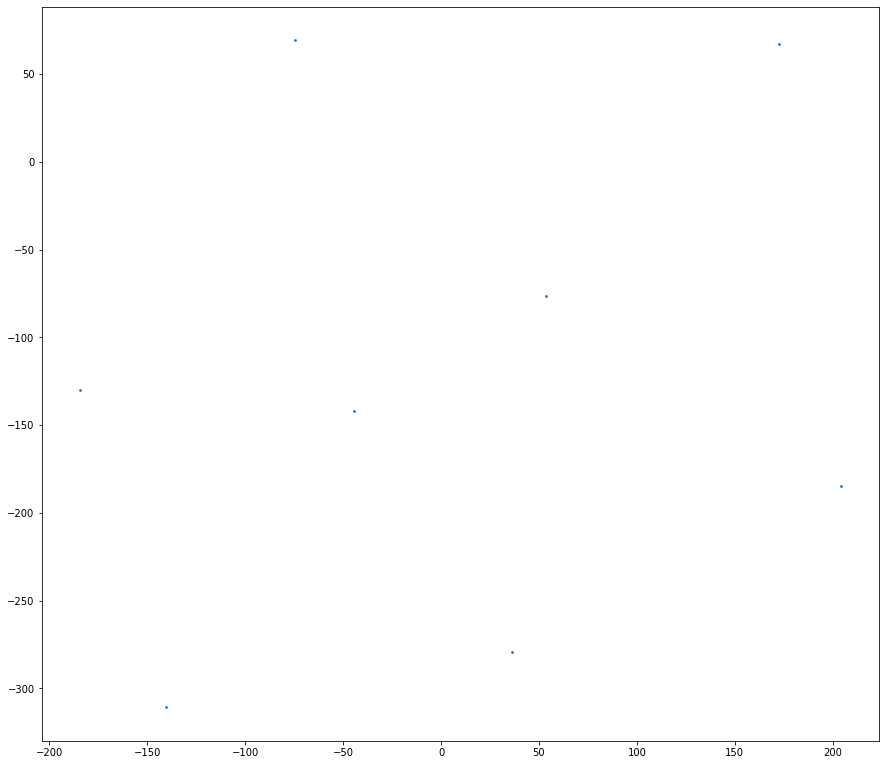

In [25]:
doc_pca = PCA(n_components=5).fit_transform(doc_matrix)
tsne = TSNE(n_components=2, perplexity=5).fit_transform(doc_pca)


fig, ax = plt.subplots()
ax.scatter(tsne[:,0], tsne[:,1],s=3)
# for x, y, token in zip(tsne[:,0],tsne[:,1],mft):
#     ax.annotate(token, xy=(x,y), size=10)

fig.set_size_inches(15,13.5)
# fig.savefig('./plots/word_embeddings.pdf',dpi=300)
fig.show()

